Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "Quanpu Xiao"
STUDENT_ID = "14368978"

---

*Objective*: Apply topic modelling techniques, such as Latent Dirichlet Allocation (LDA), to analyze and interpret the primary topics present in a collection of online news articles.

Topic modelling is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. It is a frequently used text-mining tool for the discovery of hidden semantic structures in a text body. This assignment involves implementing and interpreting LDA topic modelling on a dataset of online news articles to understand the prevalent themes and topics.

For this task, you will use the "Fake news" dataset, which contains information about a large number of fake news articles. The dataset is available here: https://www.kaggle.com/datasets/mrisdal/fake-news.

1. Prepare: Explore the dataset
2. Pre-process the text data
3. Implement the LDA model
4. Analyze the topics and interpret the results

### Setup and requirements
First, make sure that you have the needed libraries for Python correctly installed.

In [2]:
#!pip install numpy pandas matplotlib sklearn gensim nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora, models
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kalei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kalei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kalei\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Prepare and Explore the Dataset (1 point)

The first step is to download and load the dataset. Familiarize yourself with its structure and content. Understand the kind of articles included, and how the data is organized.


1. Load the dataset using pandas.
2. Explore the dataset. What columns does it include? How are the articles represented?
3. For exploration purposes and initial model training take 15-35% sample of dataframe using the sample method in pandas
4. Store your dataset in the variable named `news_df`

In [3]:
import pandas as pd

news_df = ...


# YOUR CODE HERE
news_df = pd.read_csv('fake.csv')

print(news_df.columns)
print(news_df.head())

news_df = news_df.sample(frac=0.25)

print(len(news_df))

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')
                                       uuid  ord_in_thread  \
0  6a175f46bcd24d39b3e962ad0f29936721db70db              0   
1  2bdc29d12605ef9cf3f09f9875040a7113be5d5b              0   
2  c70e149fdd53de5e61c29281100b9de0ed268bc3              0   
3  7cf7c15731ac2a116dd7f629bd57ea468ed70284              0   
4  0206b54719c7e241ffe0ad4315b808290dbe6c0f              0   

                 author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3                Fed Up  2016-11-01T05:22:00.000+02:00   
4                Fed Up  2016-11-01T

In [4]:
assert 1949 <= len(news_df) <= 4550, "You should sample between 15-35% of the dataset."

### Question 1: Dataset Exploration (1 point)


What are the key characteristics of this dataset? Describe the dataset in terms of its size, variety of articles, and any other notable features.

In [5]:
# YOUR CODE HERE
num_articles = len(news_df)
num_columns = len(news_df.columns)

column_names = news_df.columns

sample_articles = news_df['text'].sample(5)

missing_values = news_df.isnull().sum()

results = {
    "Number of Articles": num_articles,
    "Number of Columns": num_columns,
    "Column Names": column_names,
    "Sample Articles": sample_articles,
    "Missing Values per Column": missing_values
}

results

{'Number of Articles': 3250,
 'Number of Columns': 20,
 'Column Names': Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
        'language', 'crawled', 'site_url', 'country', 'domain_rank',
        'thread_title', 'spam_score', 'main_img_url', 'replies_count',
        'participants_count', 'likes', 'comments', 'shares', 'type'],
       dtype='object'),
 'Sample Articles': 12947    While we (the U.S. gov't) have been spending m...
 2337     Dr. David Duke & Farren Shoaf – Countdown 7 da...
 9144     Colorado Radio Station’s Paul Martin Interview...
 12971    Everyone loved the SpaceX video of spaceship g...
 6486     Keywords: Better Tasting Food , GMOs , homeste...
 Name: text, dtype: object,
 'Missing Values per Column': uuid                     0
 ord_in_thread            0
 author                 629
 published                0
 title                  151
 text                    11
 language                 0
 crawled                  0
 site_url             

## 2. Pre-process the Text Data

Before applying topic modelling, it's crucial to pre-process the text data. This involves cleaning the text, removing stop words, and converting the text into a suitable format for analysis.

1. Complete the `preprocess_text()` function to clean the text data (remove punctuation, lowercase, tokenize, lemmatize).
2. Remove stopwords using the NLTK library.
3. Create a corpus required for the LDA model using the gensim package and save it in variable `corpus`.
3. Convert the cleaned text into a document-term matrix using the gensim package and save it in variable `doc_term_matrix`.

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel



lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # YOUR CODE HERE
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens


corpus = ...
doc_term_matrix = ...

# YOUR CODE HERE
processed_texts = [preprocess_text(text) for text in news_df['text'].dropna()]

# Remove stopwords
stop_words = set(stopwords.words('english'))
processed_texts = [[word for word in text if word not in stop_words] for text in processed_texts]

# Gensim Dictionary from the processed texts
dictionary = corpora.Dictionary(processed_texts)

# Corpus
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Document-Term Matrix
doc_term_matrix = [[(dictionary[id], freq) for id, freq in corp] for corp in corpus]

Public test (1 point)

In [7]:
assert type(doc_term_matrix) == list, "doc_term_matrix should be a list of lists"
assert type(corpus) == list, '''(gensim.corpora.dictionary.Dictionary)''' "corpus should be a gensim.corpora.dictionary.Dictionary"

Hidden tests (2 points)

### Question 2: Pre-processing Importance (2 points)

Why is pre-processing important in topic modelling? Describe how each step in the pre-processing pipeline contributes to the overall analysis.

Pre-processing will significantly influences the quality and interpretability of the results of topic modeling algorithms, since they work by identifying patterns of word usage across the dataset.

1. Text cleaning as first step will remove punctuation and lowercasing all characters, to standardize the text and refuce noise of text data.
2. Tokenization will break the text into indivisual tokens, which then can be process by the algorithms.
3. Lemmatization can convert words to their base from, so different forms of a same word are recognized as the same term.
4. Removing stop words can eliminate commonly used words that with less value to the context of the text.
5. Document-term matrix will present documents in a structured form that algorithms can then process.

## 3. Implement the LDA Model (1 point)

Now, it's time to implement the LDA model using the Gensim library. Be sure to check out the documentation for hyperparameter settings.

1. Choose the number of topics for the model. This is a crucial step and may require some experimentation.
2. Train the LDA model on the dataset.
3. Save the model for future use.

In [8]:
lda_model = ...
# YOUR CODE HERE
num_topics = 10

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

lda_model.save('lda_model.gensim')


In [9]:
assert type(lda_model) == gensim.models.ldamodel.LdaModel, "lda_model should be a gensim.models.ldamodel.LdaModel"
lda_model.save('lda_model.model')

### Question 3: Model Parameters (2 points)

Discuss the choice of number of topics for the LDA model. How does this choice impact the model's performance and the interpretability of the results?

I started with 10 topics then tried 100 topics. Less topic will significantly reduce model traning time, resulting a better performance in terms of time. With that being said, too few topics will generate over broad topics and too many topics will massively increase traning time as well as too narrowly focused topics that may overlap with each other. In conlcusion, a proper amount of topic is crucial for LDA model and it should be obtained throught experiments and our subjective judgment based on the results.

## 4. Analyze Topics and Interpret Results (1 point)

Finally, analyze the topics produced by the LDA model and interpret the results.

1. Use the LDA model to identify the main topics in the dataset.
2. For each topic, examine the most representative words.
4. Interpret the topics: What themes or subjects do they represent?

### Question 4: Topic Interpretation

Interpret the topics generated by the LDA model. How coherent are the topics? What do they tell us about the content of the dataset? Does this model need improvement by modifying parameters, using further pre-processing?

In [10]:
# YOUR CODE HERE
num_words = 10

# Extracting topics with their most representative words
topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

for topic_no, topic_words in topics:
    words = ', '.join([word for word, prob in topic_words])
    print(f"Topic {topic_no}: {words}")

Topic 0: water, crystalline, universe, energy, italy, fukushima, planet, earth, scientist, earthquake
Topic 1: health, food, drug, study, medical, corrupt, cancer, body, brain, disease
Topic 2: ’, “, ”, wa, one, people, like, time, know, get
Topic 3: de, la, que, el, en, un, los, e, se, le
Topic 4: clinton, ’, “, ”, email, hillary, wa, fbi, —, said
Topic 5: в, и, на, с, что, не, по, как, », а
Topic 6: amanda, froelich, giver, vocation, woodland, breathtaking, cliven, fiore, glutathione, gillespie
Topic 7: euro, der, die, und, da, von, zu, den, um, er
Topic 8: u, ’, ha, “, ”, wa, war, state, government, people
Topic 9: trump, election, donald, ha, american, vote, obama, state, president, hillary


Based on the topics generated by the LDA model, some topics show a high level of coherence such as topic 9 showing focus on health and medicine, also topic 8 clearly showing content related to Hillary Clinton. For improvement, further preprocessing is needed since we are getting topics like 2, 5 that are purely made of stopwords from other languages. Removing stopwords from other languages could help to avoid this.

## Question 5: Improving Preprocessing for Topic Modeling (1 point)

### Objective:
Enhance your understanding and skills in preprocessing text data for topic modeling. You will focus on two key areas: 
1. Subsetting posts by language (focusing on English).
2. Enriching the list of stopwords specific to your dataset for more effective topic modeling by adding custom stopwords. Analyze the results to identify irrelevant or overly common words that could be added to your stopwords list.
3. **Re-run Topic Modeling**: Apply the enriched stopwords list and re-run the topic modeling process.

In [11]:
# subset dataset by english articles
# news_df = ...

# YOUR CODE HERE
from langdetect import detect, LangDetectException

def detect_language(text):
    if isinstance(text, str) and text.strip():
        try:
            return detect(text)
        except LangDetectException:
            return None
    else:
        return None

news_df['language'] = news_df['text'].apply(lambda x: detect_language(x) if x is not None else None)
news_df = news_df[news_df['language'] == 'en']

custom_stopwords = set([])

# YOUR CODE HERE
from collections import Counter

word_freq = Counter(word for text in processed_texts for word in text)

# Top 25 common words
potential_stopwords = [word for word, freq in word_freq.most_common(25)]

custom_stopwords = potential_stopwords

# Combine with existing stopwords
stop_words = set(stopwords.words('english')).union(custom_stopwords)


def preprocess_text(text):
    # YOUR CODE HERE
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

processed_texts = [preprocess_text(text) for text in news_df['text'].dropna()]

# Remove stopwords
stop_words = stop_words
processed_texts = [[word for word in text if word not in stop_words] for text in processed_texts]

# Gensim Dictionary from the processed texts
dictionary = corpora.Dictionary(processed_texts)

# Corpus
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Document-Term Matrix
doc_term_matrix = [[(dictionary[id], freq) for id, freq in corp] for corp in corpus]


# YOUR CODE HERE
num_topics = 10

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

lda_model.save('lda_model.gensim')

topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

for topic_no, topic_words in topics:
    words = ', '.join([word for word, prob in topic_words])
    print(f"Topic {topic_no}: {words}")


Topic 0: war, russia, military, russian, force, country, syria, united, president, putin
Topic 1: gold, sprott, opec, silver, sand, ounce, armstrong, kwn, sixty, astronaut
Topic 2: right, many, ‘, way, get, make, know, say, day, thing
Topic 3: human, system, source, planet, energy, information, earth, science, technology, universe
Topic 4: health, food, drug, study, cancer, water, medical, body, disease, sugar
Topic 5: donald, vote, voter, republican, candidate, party, voting, president, poll, democrat
Topic 6: bank, million, company, pipeline, money, 2016, economic, business, access, financial
Topic 7: email, fbi, investigation, comey, department, agent, case, official, information, justice
Topic 8: obama, campaign, president, podesta, email, bill, house, wikileaks, —, administration
Topic 9: israel, palestinian, israeli, netanyahu, seat, palestine, jew, jewish, jerusalem, morocco


Does this additional preprocessing improve the topic model output? Why?

This additional preprocessing significantly improved the topic generated by LDA model, since now we are only dealing with english text and having a richer stopwords list to avoid generating topics based on stopwords as before.

## Question 6. Assessing LDA Model Coherence (2 points)

### Objective

In this exercise, you will assess the coherence of an LDA topic model using Gensim's coherence measures. Coherence measures help in evaluating how well the topics generated by the model are interpretable and semantically meaningful.

### Task

1. **Implement an LDA Model**: Using the "Fake news" dataset, implement an LDA model as done in the previous exercises.
2. **Compute Coherence Score**: Calculate the coherence score of your model using Gensim's CoherenceModel (https://radimrehurek.com/gensim/models/coherencemodel.html).
3. **Experiment with Different Number of Topics**: Experiment with different numbers of topics (e.g., 5, 10, 15 or 10, 50, 100 or whatever range you deem likely for the given data) and assess how the coherence score changes. Write a function that computes a coherence score for each model and plot the coherence scores associated with each topic number value (1 point).
4. **Interpret Results**: Based on the coherence scores, determine the optimal number of topics for the model (1 point).

### Assessment Criteria

- Quality of LDA model implementation.
- Correct calculation and interpretation of coherence scores.
- Thoughtful experimentation with different numbers of topics and analysis of the impact on coherence.

---

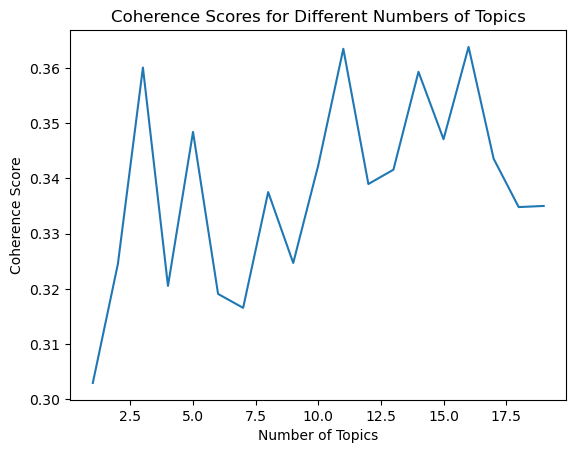

In [12]:
from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence score
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    # YOUR CODE HERE
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Applying the function to our dataset
model_list, coherence_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=processed_texts, start=2, limit=40, step=2)

# Plotting coherence scores
# YOUR CODE HERE
topic_values = range(1, 20, 1)

plt.plot(topic_values, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.show()

What is the optimal number of topics for your model?

In [13]:
# YOUR CODE HERE
optimal_num_topics = topic_values[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is: {optimal_num_topics}")

The optimal number of topics is: 16


## Question 7: Fitting the Final LDA Model on the Entire Dataset (4 points)

### Objective:
Having identified the optimal number of topics using the coherence model in Gensim, your task now is to apply this knowledge to fit the final LDA (Latent Dirichlet Allocation) model on the entire dataset.

### Instructions:

1. **Optimal Number of Topics**:
   - Recall the optimal number of topics you determined using the coherence model on a sample of your dataset.
   
2. **Preprocess the Full Dataset**:
   - Ensure that the entire dataset is properly preprocessed (tokenization, removing stopwords, etc.).
   - Create a dictionary and a bag-of-words corpus using the full dataset.

3. **Fit the LDA Model**:
   - Instantiate and train the LDA model on the entire dataset using the optimal number of topics you previously determined.
   - Use the same model parameters that were most effective during your experimentation with the sample.

4. **Model Evaluation**:
   - Briefly evaluate the model by examining the coherence score on the full dataset.
   - Display the top words for each topic and provide a brief interpretation.

5. **Reflection**:
   - Reflect on any differences observed in topic quality and coherence when the model is applied to the entire dataset versus the sample.

In [15]:
# YOUR CODE HERE
processed_texts = [preprocess_text(text) for text in news_df['text']]

processed_texts = [[word for word in text if word not in stop_words] for text in processed_texts]

dictionary = corpora.Dictionary(processed_texts)

# Corpus
corpus = [dictionary.doc2bow(text) for text in processed_texts]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

num_words = 10
topics = lda_model.show_topics(num_topics=optimal_num_topics, num_words=num_words, formatted=False)
for topic_no, topic_words in topics:
    words = ', '.join([word for word, prob in topic_words])
    print(f"Topic {topic_no}: {words}")

# Reflection
# The topic quality in general seems to be solid, better than with only sample data, and come with a higher coherence score. However, a website link is observered in topic 8 means better preprocessing could be done to remove the link.

Coherence Score: 0.5751483264396415
Topic 0: nuclear, israel, iran, china, israeli, philippine, , navy, duterte, kennedy
Topic 1: star, planet, extraterrestrial, energy, ufo, earth, scientist, solar, formation, space
Topic 2: get, know, make, right, many, way, thing, life, going, want
Topic 3: bank, money, company, million, market, system, percent, rate, business, financial
Topic 4: water, health, food, study, drug, body, medical, cancer, research, disease
Topic 5: vote, voter, voting, poll, ballot, donald, machine, county, percent, candidate
Topic 6: 2016, news, —, ‘, october, report, day, comment, november, post
Topic 7: email, fbi, investigation, comey, department, podesta, campaign, case, agent, foundation
Topic 8: switch, infowars, brain, httpwwwinfowarsstorecomhealthandwellnessinfowarslifebrainforcehtmlimstzrwuutmcampaigninfowarsplacementutmsourceinfowarscomutmmediumwidgetutmcontentbrainforce, jones, flip, force, alex, activation, neural
Topic 9: assange, permit, julian, muammar